[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/upernet_inference_pretrained.ipynb)

In [ ]:
# make sure you have the latest version of the libraries
!pip install -U segmentation-models-pytorch
!pip install albumentations matplotlib requests pillow

In [1]:
import requests
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

import torch
import segmentation_models_pytorch as smp

from PIL import Image

/home/ubuntu/projects/segmentation_models.pytorch/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# More checkpoints can be found here:
# https://huggingface.co/collections/smp-hub/upernet-67fadcdbe08418c6ea94f768
checkpoint = "smp-hub/upernet-swin-tiny"

# Load pretrained model and preprocessing function
model = smp.from_pretrained(checkpoint).eval().to(device)
preprocessing = A.Compose.from_pretrained(checkpoint)
print("Preprocessing:\n", preprocessing)

# Load image
url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Preprocess image
image = np.array(image)
normalized_image = preprocessing(image=image)["image"]
input_tensor = torch.as_tensor(normalized_image)
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  # HWC -> BCHW
input_tensor = input_tensor.to(device)

# Perform inference
with torch.inference_mode():
    output_mask = model(input_tensor)

# Postprocess mask
mask = torch.nn.functional.interpolate(
    output_mask, size=image.shape[:2], mode="bilinear", align_corners=False
)
mask = mask[0].argmax(0).cpu().numpy()

Preprocessing:
 Compose([
  Resize(p=1.0, height=512, width=512, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, normalization='standard'),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


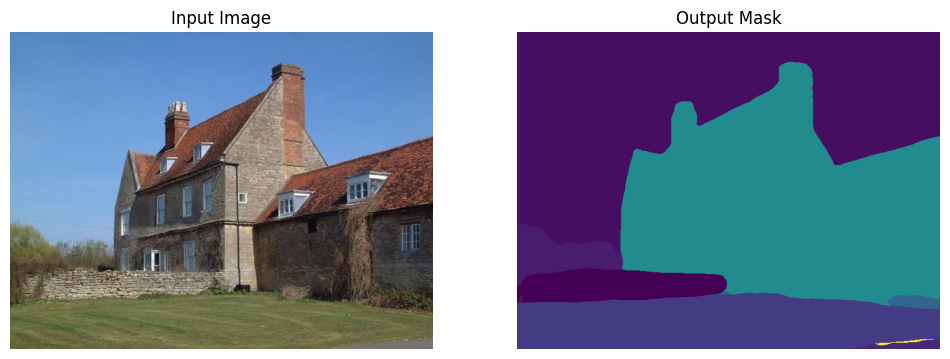

In [6]:
# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.axis("off")
plt.imshow(image)
plt.title("Input Image")

plt.subplot(122)
plt.axis("off")
plt.imshow(mask)
plt.title("Output Mask")

plt.show()